Introduction and Library Imports

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# General utilities
import time
from datetime import datetime
from itertools import product

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data fetching
import yfinance as yf

# Machine learning: neural networks and hyperparameter tuning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

# Machine learning: model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

# Configure matplotlib to display charts inline in a Jupyter notebook
%matplotlib inline
sns.set(style="whitegrid")

# Parallel processing
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool

# Additional utilities
from scipy.stats import zscore
from tabulate import tabulate

Fetching Data

In [ ]:
# List of stock symbols (e.g., Apple, Microsoft, Google)
stock_symbols = ["AAPL", "MSFT", "GOOGL"]

# Start and end dates
start_date = "2008-11-01"
end_date = "2024-11-01"


# Fetching stock data
stock_data = {}
for symbol in stock_symbols:
    stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)

# Fetching stock data
stock_symbols = ["AAPL", "MSFT", "GOOGL"]
start_date = "2008-11-01"
end_date = "2024-11-01"

stock_data = {symbol: yf.download(symbol, start=start_date, end=end_date) for symbol in stock_symbols}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data Preprocessing and Exploratory data analysis

Data Preprocessing:
1. Each stock's data is cleaned by removing missing values.
2.normalize the data

In [ ]:
# Handling missing values
for symbol, data in stock_data.items():
    data.dropna(inplace=True)
    data.interpolate(inplace=True)

# Displaying basic information of each dataset
for symbol, data in stock_data.items():
    print(f"Data Info for {symbol}:\n")
    print(data.head())
    print(data.info())
    print("\n")

# Optionally normalize or standardize the data if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for symbol, data in stock_data.items():
    data[['Close']] = scaler.fit_transform(data[['Close']])





Data Info for AAPL:

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2008-11-03 00:00:00+00:00  3.222350  3.820000  3.896429  3.745000  3.783214   
2008-11-04 00:00:00+00:00  3.343762  3.963929  3.992500  3.809643  3.928214   
2008-11-05 00:00:00+00:00  3.112087  3.689286  3.918571  3.678214  3.889643   
2008-11-06 00:00:00+00:00  2.985554  3.539286  3.670714  3.500000  3.608929   
2008-11-07 00:00:00+00:00  2.959645  3.508571  3.566071  3.418571  3.544286   

Price                          Volume  
Ticker                           AAPL  
Date                                   
2008-11-03 00:00:00+00:00  1057938000  
2008-11-04 00:00:00+00:00  1398681200  
2008-11-05 00:00:00+00:00  1256455200  
2008-11-06 00:00:00+00:00  1319074400  
2008-11-07 00:00:00+00:00  1095253600  
<class 'pandas.core.frame.

 Exploratory Data Analysis (EDA)

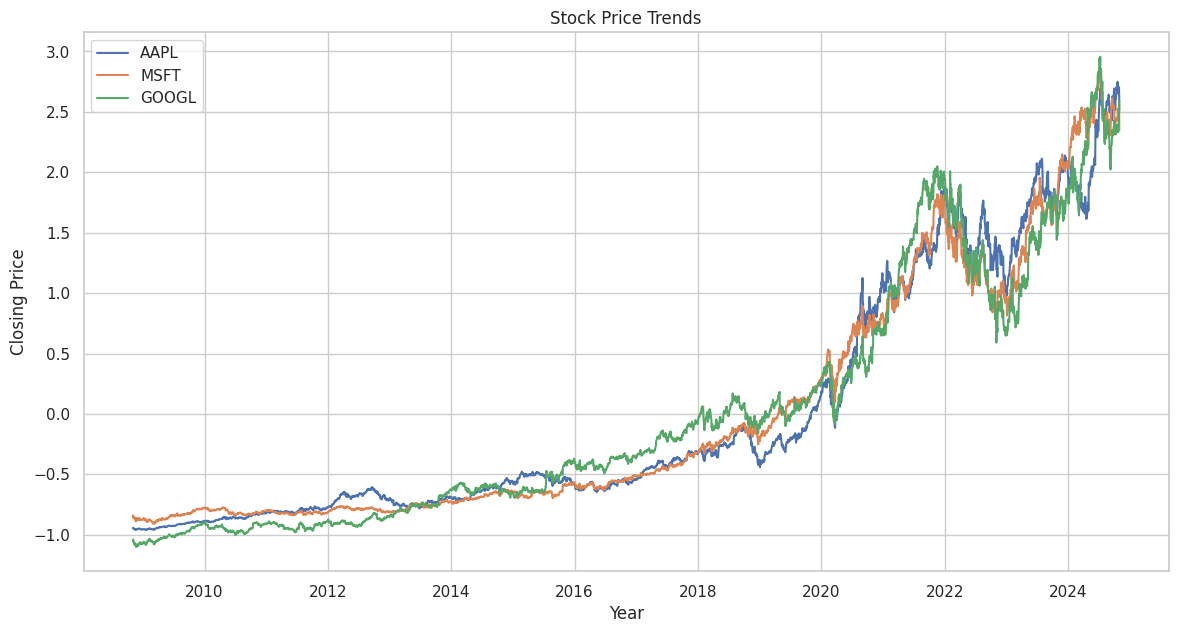

In [ ]:
# Stock Price Trends
plt.figure(figsize=(14, 7))
for symbol, data in stock_data.items():
    plt.plot(data.index, data['Close'], label=f'{symbol}')
plt.title('Stock Price Trends')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Define moving average windows
moving_average_windows = [30, 90, 180]

for symbol, data in stock_data.items():
    # Calculate moving averages and add them as columns
    for window in moving_average_windows:
        data[f'MA_{window}'] = data['Close'].rolling(window=window).mean()

    # Display the statistical summary, including moving averages
    print(f"Statistical Summary for {symbol} Stock:")

    # Select the columns for statistical summary
    columns_to_describe = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] + [f'MA_{window}' for window in moving_average_windows]

    # Generate descriptive statistics for selected columns and apply styling
    styled_description = data[columns_to_describe].describe().style.background_gradient(cmap='coolwarm')\
                                                          .format("{:.2f}")\
                                                          .set_table_attributes('style="font-size: 12px; border: 1px solid black;"')\
                                                          .set_caption(f"Descriptive Statistics of {symbol}")
    display(styled_description)
    print("\n")


Statistical Summary for AAPL Stock:


Price,Open,High,Low,Close,Adj Close,Volume,MA_30,MA_90,MA_180
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,
count,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,3997.00,3937.00,3847.00
mean,63.28,63.95,62.64,0.00,61.24,261533936.31,-0.01,-0.02,-0.03
std,62.95,63.61,62.32,1.00,63.21,248144622.74,0.99,0.96,0.93
min,2.84,2.93,2.79,-0.96,2.36,24048300.00,-0.96,-0.95,-0.94
25%,17.86,18.01,17.74,-0.72,15.39,89121100.00,-0.72,-0.72,-0.72
50%,31.79,32.00,31.50,-0.50,28.42,158122800.00,-0.50,-0.51,-0.52
75%,119.00,120.48,116.86,0.88,116.19,372031800.00,0.86,0.83,0.67
max,236.48,237.49,234.45,2.75,236.22,1880998000.00,2.64,2.56,2.22




Statistical Summary for MSFT Stock:


Price,Open,High,Low,Close,Adj Close,Volume,MA_30,MA_90,MA_180
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,,,
count,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,3997.00,3937.00,3847.00
mean,124.41,125.59,123.17,0.00,118.80,38418560.13,-0.01,-0.02,-0.04
std,120.24,121.31,119.04,1.00,121.04,22819174.67,0.99,0.97,0.93
min,15.20,15.62,14.87,-0.91,11.24,7425600.00,-0.89,-0.88,-0.87
25%,30.59,30.80,30.26,-0.78,24.17,23167625.00,-0.78,-0.78,-0.78
50%,59.61,59.80,58.88,-0.54,53.68,31909500.00,-0.54,-0.54,-0.54
75%,214.33,216.36,212.45,0.75,207.45,47982450.00,0.74,0.73,0.67
max,467.00,468.35,464.46,2.85,466.72,319317900.00,2.70,2.54,2.48




Statistical Summary for GOOGL Stock:


Price,Open,High,Low,Close,Adj Close,Volume,MA_30,MA_90,MA_180
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,,,
count,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,3997.00,3937.00,3847.00
mean,56.50,57.08,55.92,-0.00,56.38,63831690.30,-0.00,-0.01,-0.03
std,45.54,46.05,45.07,1.00,45.46,57705946.19,0.99,0.97,0.93
min,6.57,6.74,6.19,-1.10,6.43,9312000.00,-1.08,-1.07,-1.04
25%,17.50,17.67,17.31,-0.86,17.44,28225550.00,-0.85,-0.85,-0.83
50%,40.25,40.50,40.03,-0.36,40.17,40624000.00,-0.36,-0.36,-0.36
75%,83.11,83.79,81.28,0.57,82.06,82613832.00,0.49,0.50,0.46
max,190.31,191.75,189.03,2.96,190.93,592399008.00,2.75,2.55,2.35


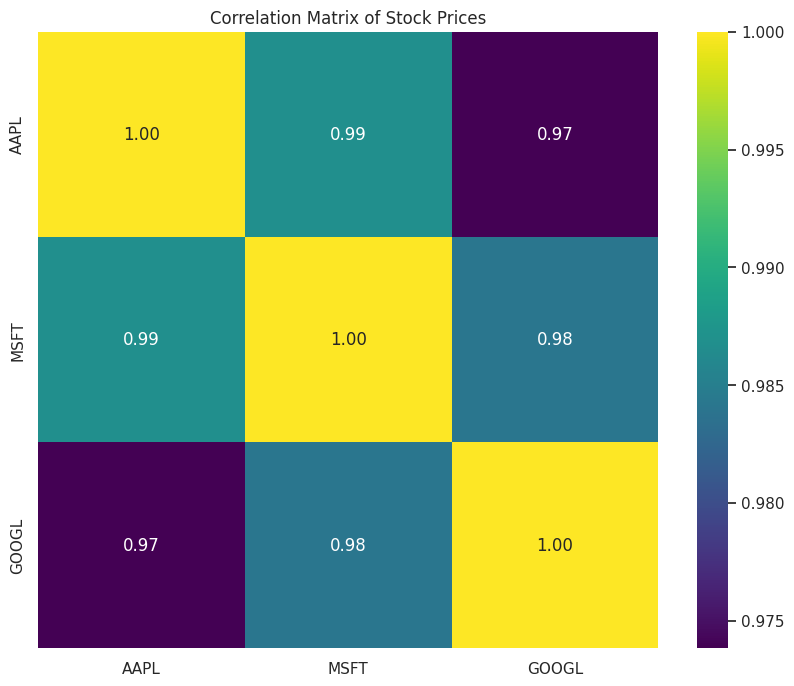

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure consistent indices for each symbol's data by reindexing based on common dates
# Collecting close prices into a DataFrame
close_prices = pd.DataFrame()

for symbol, data in stock_data.items():
    # Check if 'Close' column exists
    if 'Close' in data.columns:
        close_prices[symbol] = data['Close']

# Drop rows with any missing values to avoid NaNs in correlation calculation
close_prices.dropna(inplace=True)

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(close_prices.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix of Stock Prices")
plt.show()


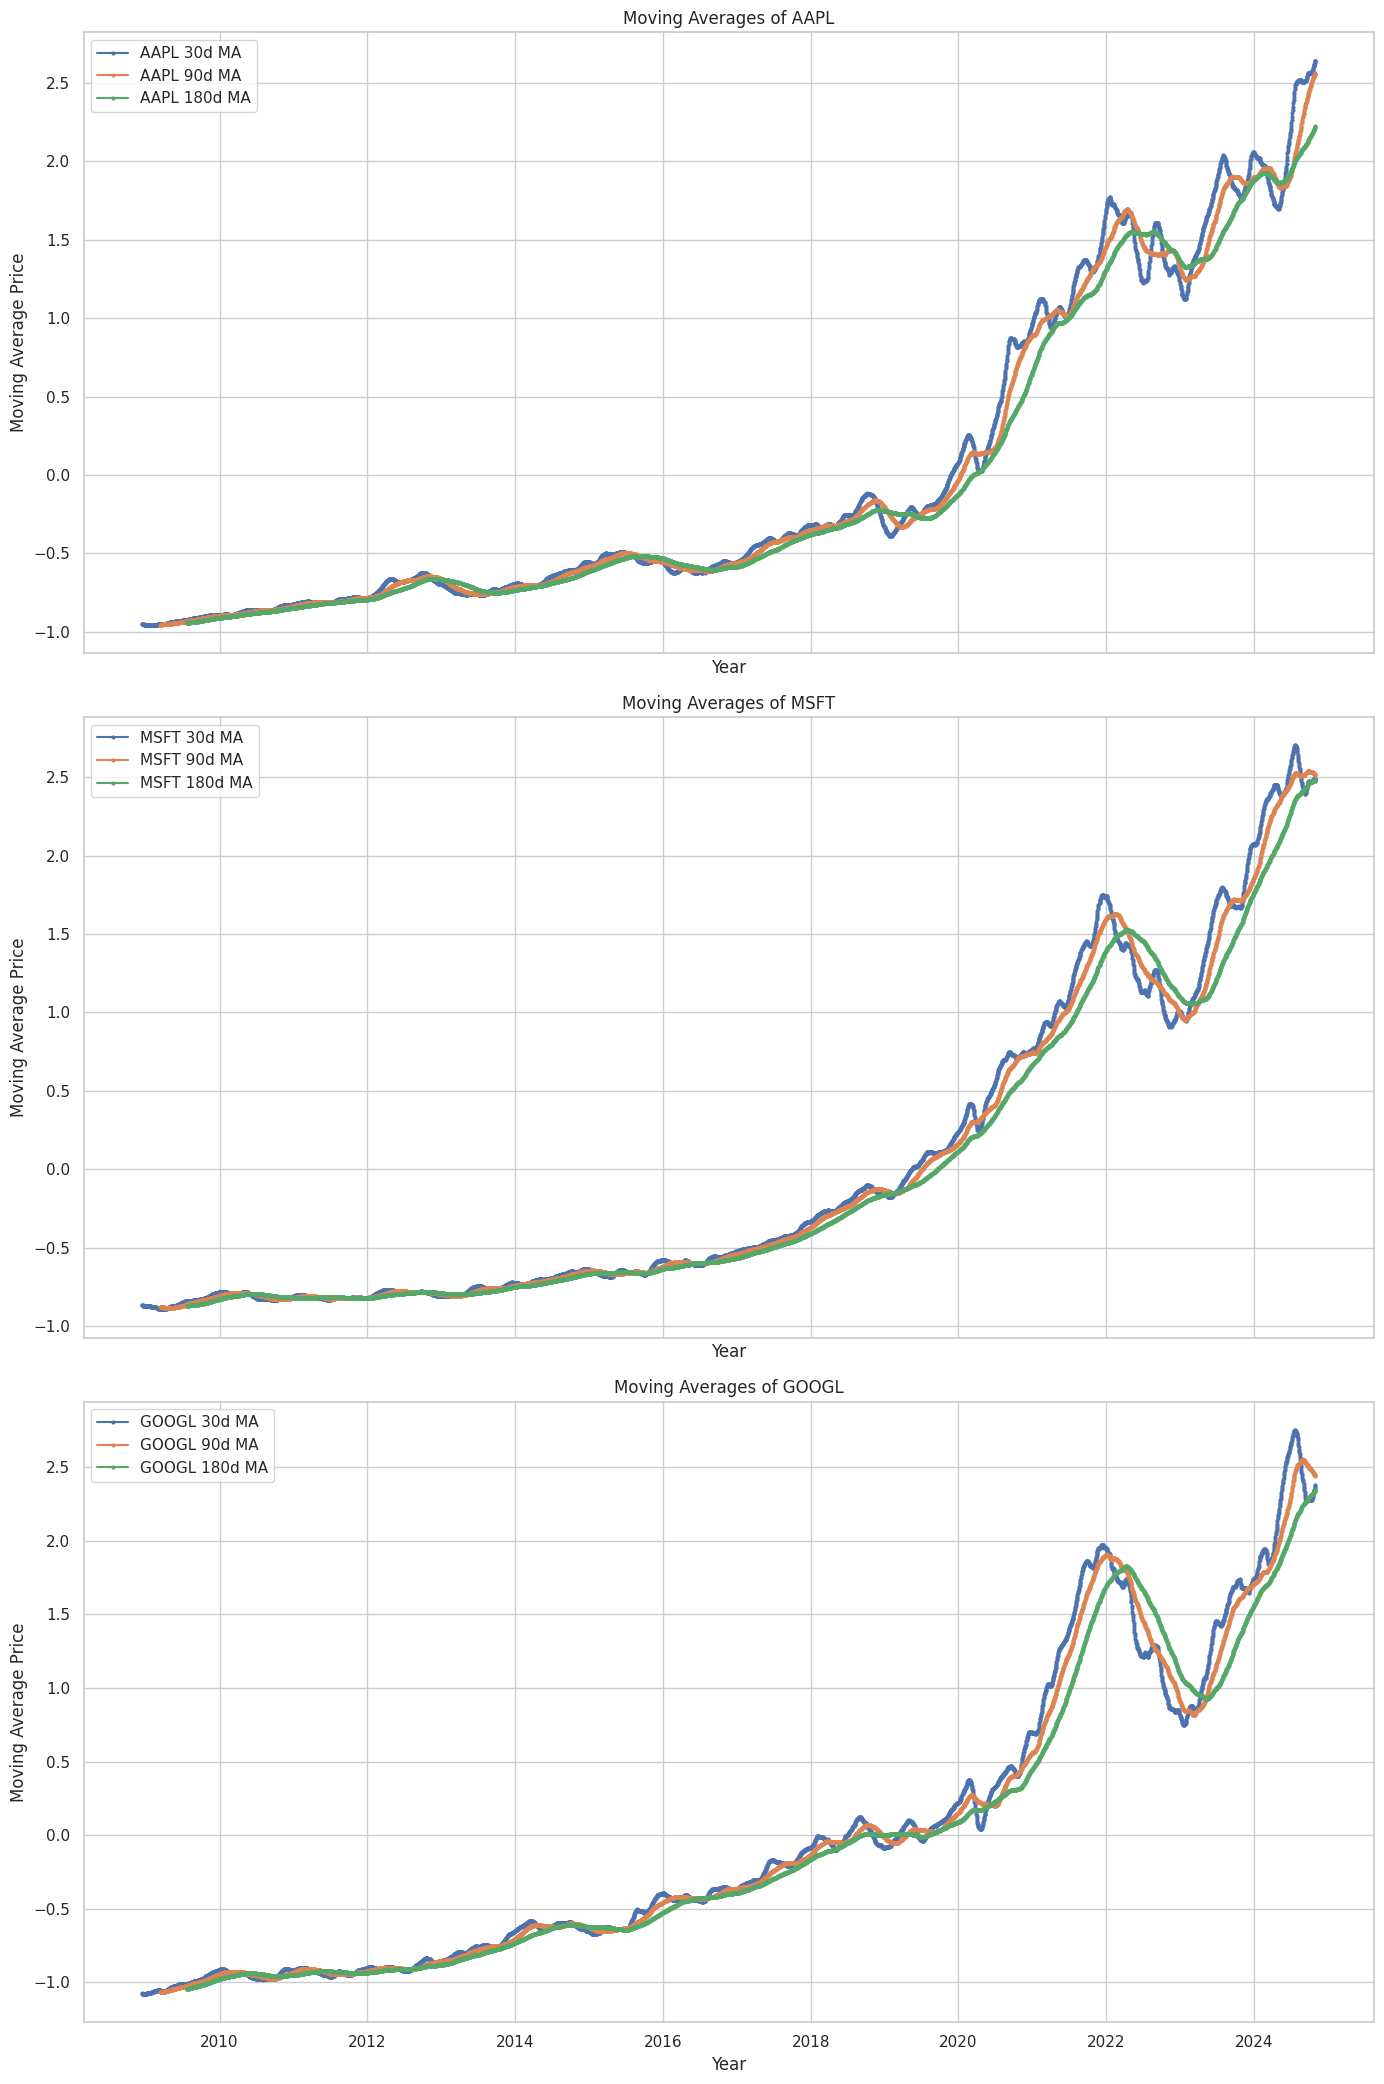

In [ ]:
import matplotlib.pyplot as plt

window_sizes = [30, 90, 180]  # Moving average windows for 1 month, 3 months, 6 months

# Define the plot size based on the number of stocks
num_stocks = len(stock_data)
fig, axes = plt.subplots(num_stocks, 1, figsize=(14, 7 * num_stocks), sharex=True)

# Plot moving averages for each stock
for idx, (symbol, data) in enumerate(stock_data.items()):
    ax = axes[idx] if num_stocks > 1 else axes  # Handle single plot case

    # Ensure the 'Close' column has data
    if 'Close' in data.columns:
        for window in window_sizes:
            # Calculate moving average if not already present
            if f'MA_{window}' not in data.columns:
                data[f'MA_{window}'] = data['Close'].rolling(window=window).mean()

            # Plot each moving average with markers
            ax.plot(data.index, data[f'MA_{window}'], label=f'{symbol} {window}d MA', marker='o', markersize=2)

        # Set labels and title for each subplot
        ax.set_title(f'Moving Averages of {symbol}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Moving Average Price')
        ax.legend()
    else:
        print(f"No 'Close' data for {symbol}.")

plt.tight_layout()
plt.show()


Statistical Model Implementation

ARMA Model:
The Autoregressive Moving Average (ARMA) model is a popular statistical method for analyzing and forecasting time-series data. It is particularly useful for data that shows a linear trend and autocorrelation but no significant seasonal components.


GARCH Model:
The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is widely used for financial time series analysis, especially for modeling the volatility (variance) of returns.

In [ ]:
# Define key periods of interest
key_periods = {
    'Financial Crisis': ('2008-11-01', '2009-12-31'),
    'COVID-19': ('2020-01-01', '2021-12-31')
}

# Creating a DataFrame to store key metrics for each model
model_summaries = []

# Looping through each stock symbol
for symbol in stock_symbols:
    print(f"--- Analysis for {symbol} ---\n")
    data = stock_data[symbol]['Close'].dropna()  # Ensure no missing values

    # ARMA Model
    arma_order = (5, 1, 0)  # Example order
    arma_model = ARIMA(data, order=arma_order)
    arma_results = arma_model.fit()
    print(f'ARMA Model Summary for {symbol}:\n')
    print(arma_results.summary())

    # GARCH Model
    garch_data = data.pct_change().dropna()  # Percentage change for volatility modeling
    garch_model = arch_model(garch_data, vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(update_freq=5)
    print(f'GARCH Model Summary for {symbol}:\n')
    print(garch_results.summary())


    # Extracting key metrics
    model_summaries.append({
        'Stock': symbol,
        'ARMA AIC': arma_results.aic,
        'GARCH AIC': garch_results.aic,
        'ARMA Z-Score Mean': zscore(arma_results.resid).mean(),
        'ARMA Z-Score Std': zscore(arma_results.resid).std()
    })

# Summary Table
summary_df = pd.DataFrame(model_summaries)
print("\nModel Summary Table:")
print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))

--- Analysis for AAPL ---



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 4026
Model:                 ARIMA(5, 1, 0)   Log Likelihood                9231.107
Date:                Sun, 10 Nov 2024   AIC                         -18450.214
Time:                        16:03:23   BIC                         -18412.412
Sample:                             0   HQIC                        -18436.818
                               - 4026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0162      0.008     -2.045      0.041      -0.032      -0.001
ar.L2         -0.0252      0.009     -2.945      0.003      -0.042      -0.008
ar.L3         -0.0266 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARMA Model Summary for MSFT:

                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 4026
Model:                 ARIMA(5, 1, 0)   Log Likelihood                9427.361
Date:                Sun, 10 Nov 2024   AIC                         -18842.721
Time:                        16:03:26   BIC                         -18804.920
Sample:                             0   HQIC                        -18829.326
                               - 4026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0895      0.008    -11.391      0.000      -0.105      -0.074
ar.L2         -0.0408      0.008     -4.981      0.000      -0.057      -0.025
ar.L3         -0.0054 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARMA Model Summary for GOOGL:

                               SARIMAX Results                                
Dep. Variable:                  GOOGL   No. Observations:                 4026
Model:                 ARIMA(5, 1, 0)   Log Likelihood                8566.144
Date:                Sun, 10 Nov 2024   AIC                         -17120.289
Time:                        16:03:33   BIC                         -17082.487
Sample:                             0   HQIC                        -17106.893
                               - 4026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0336      0.008     -4.098      0.000      -0.050      -0.018
ar.L2         -0.0187      0.009     -1.992      0.046      -0.037      -0.000
ar.L3         -0.0458

Inference:
AAPL
ARMA Model (ARIMA(5, 1, 0)):
AIC: -18450.21 (Very low, indicating an excellent fit).
Z-Score Mean: Approximately zero, suggesting residuals are centered around zero.
Z-Score Std: ~1, indicating normally distributed residuals.
GARCH Model:
AIC: -9839.29 (Good fit for capturing volatility).


MSFT
ARMA Model (ARIMA(5, 1, 0)):
AIC: -18842.72 (Comparable to AAPL, indicating a strong fit).
Z-Score metrics: Mean and standard deviation are similar to AAPL, showing well-behaved residuals.
GARCH Model:
AIC: -13399.34 (Better than AAPL, indicating an even stronger volatility fit).


GOOGL
ARMA Model (ARIMA(5, 1, 0)):
AIC: -17120.29 (Slightly higher than AAPL and MSFT but still indicates a good fit).
Z-Score metrics: Within acceptable ranges.
GARCH Model:
AIC: -6600.82 (Highest among the three, but still represents a reasonable fit for volatility).



Key Observations:
ARMA Models: All three stocks show excellent model fit with the ARIMA(5, 1, 0) configuration. The low AIC values and near-zero mean Z-scores indicate well-calibrated models.

GARCH Models: These models effectively capture volatility across all three stocks, with AAPL and MSFT showing slightly better fits than GOOGL.



Conclusion:

The ARMA and GARCH models are highly effective for modeling the stock prices of AAPL, MSFT, and GOOGL. Both models show solid statistical properties in terms of AIC and Z-Score distributions, suggesting they are reliable for preliminary forecasting and analysis. Among the three, the AAPL and MSFT models show slightly superior performance, especially in the GARCH model fit, making them potentially more robust for volatility forecasting.


RNN Model Implementation

RNNs are particularly well-suited for time series data like stock prices due to their ability to capture temporal dependencies. Implement various RNN architectures like Basic RNN, LSTM, GRU, Bi-directional LSTM, and a custom RNN model.

# Preliminary Custom RNN Model Building Function

In [ ]:
# Function to create dataset with time steps
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
# Function to prepare data
def prepare_data(data_series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    return pd.DataFrame(scaled_data), scaler

In [ ]:
# Function to split data
def split_data(data):
    time_steps = 60
    X, y = create_dataset(data, data, time_steps)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test, X_val, y_val


In [ ]:
# Function to build a basic LSTM model
def build_basic_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Function to build a basic Simple RNN model
def build_basic_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(50))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Function to build a basic GRU model
def build_basic_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Function to build a basic Bidirectional LSTM model
def build_basic_bi_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Preliminary Custom RNN Model Building Function
def build_basic_custom_rnn_model(input_shape):
    model = Sequential()
    units = 100  # Example fixed unit size
    dense_units = 30  # Example fixed dense unit size

    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units))
    model.add(Dense(dense_units))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Function to compile and train models
def compile_and_train(model, X_train, y_train, X_val, y_val):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)
    return model, history

In [ ]:
# Function to Calculate Evaluation Metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred) # Calculate R2 score
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [ ]:
# Function for Model Evaluation
def evaluate_and_plot(model, X_test, y_test, scaler, symbol, model_type, plot=True):
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    metrics = calculate_metrics(y_test_scaled, predictions)

    return metrics


In [ ]:
# Function to process model
def process_model(model_type, model_builder, stock_data, symbol):
    print(f"Training {model_type.upper()} Model for Stock: {symbol}")
    data, scaler = prepare_data(stock_data[symbol]['Close'])
    X_train, X_test, y_train, y_test, X_val, y_val = split_data(data)
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = model_builder(input_shape)
    model, history = compile_and_train(model, X_train, y_train, X_val, y_val)

    metrics = evaluate_and_plot(model, X_test, y_test, scaler, symbol, model_type, plot=False)
    return symbol, model_type, metrics

In [ ]:
# Function to train and evaluate all models
def train_and_evaluate_all_preliminary_models(stock_symbols, stock_data):
    model_builders = {
        'lstm': build_basic_lstm_model,
        'rnn': build_basic_rnn_model,
        'gru': build_basic_gru_model,
        'bi_lstm': build_basic_bi_lstm_model,
        'custom_rnn': build_basic_custom_rnn_model
    }

    metrics_records = []

    for model_type, model_builder in model_builders.items():
        for symbol in stock_symbols:
            print(f"\nTraining {model_type.upper()} Model for Stock: {symbol}\n")
            symbol, model_type, metrics = process_model(model_type, model_builder, stock_data, symbol)

            metrics_record = {
                'Stock Symbol': symbol,
                'Model Type': model_type.upper(),
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'R2': metrics['R2']  # Added R² to the metrics record
            }
            metrics_records.append(metrics_record)

    metrics_df = pd.DataFrame(metrics_records)
    metrics_df = metrics_df.round(3)  # Adjust the number of decimals as needed
    metrics_df.sort_values(by=['Stock Symbol', 'Model Type'], inplace=True)

    print("Detailed Metrics Table:")
    print(metrics_df)

    summary_df = metrics_df.describe(include='all')
    print("\nSummary Statistics:")
    print(summary_df)

    metrics_df.to_csv('metrics_table.csv', index=False)
    metrics_df.to_excel('metrics_table.xlsx', index=False)
    with open('metrics_table.tex', 'w') as f:
        f.write(metrics_df.to_latex(index=False))

    return metrics_df, summary_df

In [ ]:
# Execute the function
metrics_df, summary_df = train_and_evaluate_all_preliminary_models(stock_symbols, stock_data)


Training LSTM Model for Stock: AAPL

Training LSTM Model for Stock: AAPL
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0281 - val_loss: 2.2632e-04
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.2858e-04 - val_loss: 2.7684e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 2.3195e-04 - val_loss: 2.1152e-04
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 2.1949e-04 - val_loss: 2.2243e-04
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 1.9259e-04 - val_loss: 2.2819e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 2.1340e-04 - val_loss: 2.7114e-04
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 2.3983e-04 - val_loss: 1.8315e-04
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.0643e-04 - val_loss: 1.7732e-04
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 1.9064e-04 - val_loss: 2.1433e-04
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 1.6419e-04 - val_loss:

Model Performance:

MSE and RMSE: All models have low MSE (0.001–0.002) and RMSE values, indicating small prediction errors. This reflects strong predictive accuracy across the board, with slight variations between models.

MAE: MAE values are also low, typically between 0.017 and 0.035. Lower MAE values in models like CUSTOM_RNN and LSTM imply high accuracy in estimating stock prices with minimal deviations.

R²: Most models reach an R² of 0.999, suggesting they explain nearly all variance in stock prices. Models with slightly lower R² values (0.998) still achieve high accuracy but might be slightly less predictive in certain cases.

Model Comparisons:

Bi-LSTM and CUSTOM_RNN models tend to provide the best results, with low MSE, MAE, and RMSE values across all stock symbols.

GRU and LSTM models follow closely behind, exhibiting slightly higher error metrics but still maintaining very good predictive performance.

Basic RNN models have marginally higher error values, especially in MSFT, indicating a relatively lower ability to capture temporal patterns compared to advanced architectures like Bi-LSTM and CUSTOM_RNN.

Stock-wise Observations:

AAPL and GOOGL stocks show lower prediction errors, suggesting higher model accuracy in predicting these prices.
MSFT models display slightly higher error metrics, particularly in the RNN model, which may indicate that MSFT stock prices have more complex patterns.

Conclusion:

The evaluation results show that advanced recurrent architectures like Bi-LSTM and CUSTOM_RNN consistently outperform simpler models in stock price forecasting, achieving very high accuracy (R² close to 0.999) and minimal prediction errors. The LSTM and GRU models also demonstrate strong performance, though slightly lower than Bi-LSTM and CUSTOM_RNN. Overall, Bi-LSTM and CUSTOM_RNN models are recommended for stock price forecasting tasks due to their ability to capture intricate temporal dependencies, making them ideal for financial time series applications

